In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv')

In [4]:
df.describe()

,ID,RecipeNumber,RecipeCode,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore
count,13636.000000,13636.000000,13636.000000,13636.000000,1.363600e+04,13636.000000,13636.000000,13636.000000,13636.000000,13636.000000
mean,121.085289,38.624377,21785.990833,2.160311,1.623713e+09,0.014520,1.098269,0.543708,4.288721,153.127897
std,116.995633,29.672351,23883.189918,10.086424,5.444020e+06,0.137323,4.166487,3.265660,1.544839,140.986908
min,0.000000,1.000000,386.000000,0.000000,1.613035e+09,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,12.000000,6504.000000,1.000000,1.622717e+09,0.000000,0.000000,0.000000,5.000000,100.000000
50%,91.000000,33.000000,14600.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
75%,148.000000,63.000000,33121.000000,1.000000,1.622718e+09,0.000000,0.000000,0.000000,5.000000,100.000000
max,724.000000,100.000000,191775.000000,510.000000,1.665756e+09,3.000000,80.000000,126.000000,5.000000,946.000000


In [5]:
# Checking for null values
df.isnull().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df.shape

(13634, 15)

In [8]:
df.nunique()

ID                     701
RecipeNumber           100
RecipeCode             100
RecipeName             100
CommentID            13634
UserID               10782
UserName             10619
UserReputation          20
CreationTimestamp     2422
ReplyCount               4
ThumbsUpCount           57
ThumbsDownCount         51
Rating                   6
BestScore              525
Recipe_Review        13370
dtype: int64

In [9]:
cor = df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson')

<Axes: >

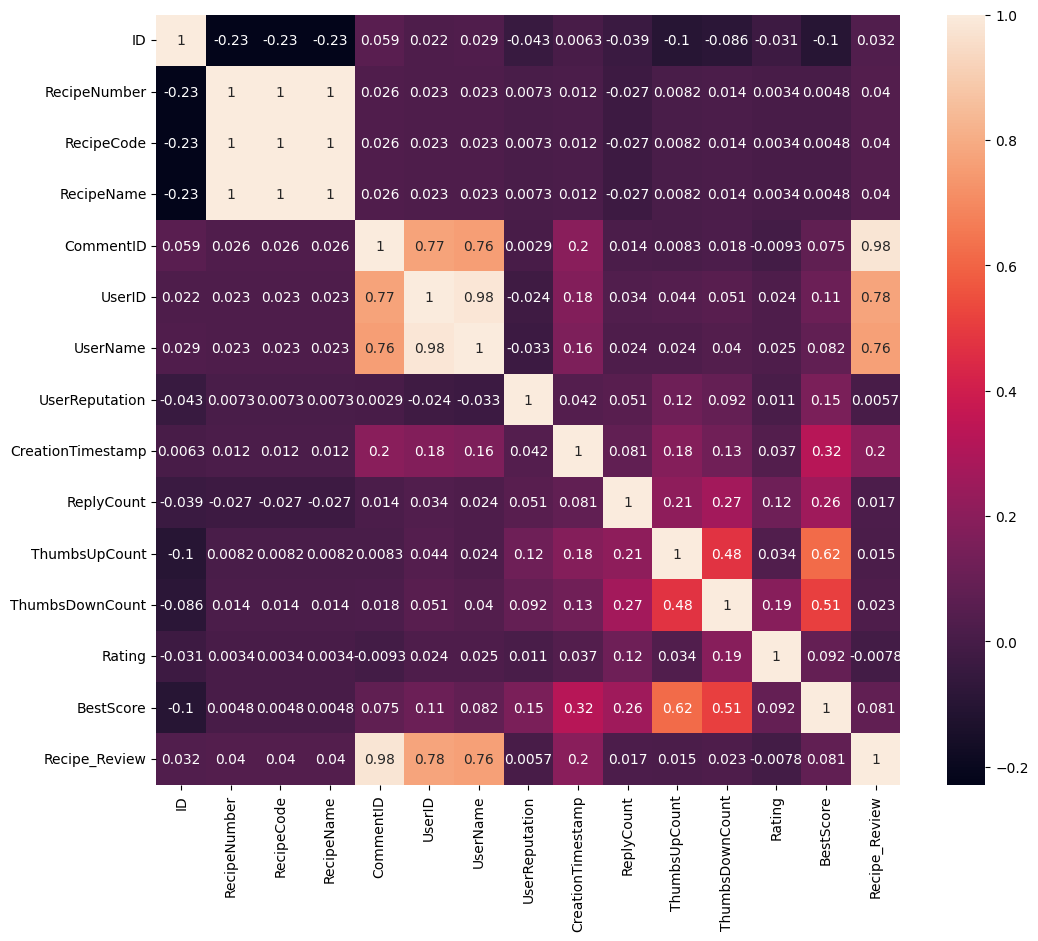

In [10]:
# It can be seen here that 'RecipeNumber', 'RecipeCode' and 'RecipeName' are fully dependent on each other so we can
# remove two of them. Moreover, 'CommentID', 'UserID' and 'UserName' also have very less correlation coeff with
# respect to 'Rating' and there are too many unique values present in all the three columns, so we can drop these
# three columns as well.
plt.figure(figsize=(12, 10))
sns.heatmap(cor, xticklabels = cor.columns, yticklabels = cor.columns, annot = True)

In [11]:
X = df.drop(['Rating'], axis = 1)
Y = df['Rating']

In [12]:
# Splitting the data into test and train data for fitting different models and checking their accuracy
# so that we know which is the best model
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [13]:
# Converting the text column 'Recipe_Review' into int values
from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer()

In [14]:
# Using MinMaxScaler to scale numerical columns
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

In [15]:
# Extracting Weekday from CreationTimestamp by using datetime 
import datetime
X_train['Weekday'] = X_train['CreationTimestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).weekday())

In [16]:
#Dropping 'UserID', 'CommentID' and 'UserName' and dropping 'RecipeName' and 'RecipeCode'
# as they depend on the column 'RecipeNumber'.
X_train = X_train.drop(['UserID', 'CommentID', 'UserName', 'RecipeName', 'RecipeCode', 'CreationTimestamp'], axis = 1)

In [17]:
X_num = list(X_train.select_dtypes(include=['int64']).columns)

In [18]:
# Using MinMaxScaler on Numerical columns and using TfidVectorizer on 'Recipe_Review' column
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('MMS', mms, X_num), ('tfi', tfid, 'Recipe_Review')], remainder = 'passthrough')

In [19]:
import datetime
X_test['Weekday'] = X_test['CreationTimestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).weekday())
X_test = X_test.drop(['UserID', 'CommentID', 'UserName', 'RecipeName', 'RecipeCode', 'CreationTimestamp'], axis = 1)

In [20]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors = 10)
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
gbc = GradientBoostingClassifier()
rfc = RandomForestClassifier()
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
svm = SVC()
lr = LogisticRegression(max_iter = 500)
from sklearn.metrics import accuracy_score

In [21]:
# Using Pipeline to use column transformer first and then running different models on the data to check
# which has highest accuracy
from sklearn.pipeline import Pipeline
pipe_lr = Pipeline([('ct', ct), ('lr', lr)])
pipe_lr.fit(X_train, Y_train)
Pred_lr = pipe_lr.predict(X_test)

In [22]:
pipe_rfc = Pipeline([('ct', ct), ('rfc', rfc)])
pipe_rfc.fit(X_train, Y_train)
Pred_rfc = pipe_rfc.predict(X_test)

In [23]:
pipe_svm = Pipeline([('ct', ct), ('svm', svm)])
pipe_svm.fit(X_train, Y_train)
Pred_svm = pipe_svm.predict(X_test)

In [24]:
pipe_gbc = Pipeline([('ct', ct), ('gbc', gbc)])
pipe_gbc.fit(X_train, Y_train)
Pred_gbc = pipe_gbc.predict(X_test)

In [25]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Pred_lr))

              precision    recall  f1-score   support

           0       0.52      0.13      0.20       369
           1       0.75      0.05      0.09        61
           2       0.00      0.00      0.00        48
           3       0.41      0.10      0.16       108
           4       0.38      0.09      0.14       396
           5       0.79      0.99      0.88      3109

    accuracy                           0.77      4091
   macro avg       0.48      0.23      0.25      4091
weighted avg       0.71      0.77      0.71      4091



In [26]:
print(classification_report(Y_test, Pred_rfc))

              precision    recall  f1-score   support

           0       0.70      0.04      0.08       369
           1       0.67      0.03      0.06        61
           2       1.00      0.04      0.08        48
           3       0.80      0.04      0.07       108
           4       0.58      0.02      0.03       396
           5       0.77      1.00      0.87      3109

    accuracy                           0.77      4091
   macro avg       0.75      0.20      0.20      4091
weighted avg       0.75      0.77      0.67      4091



In [27]:
print(classification_report(Y_test, Pred_svm))

              precision    recall  f1-score   support

           0       0.58      0.02      0.04       369
           1       1.00      0.03      0.06        61
           2       1.00      0.02      0.04        48
           3       0.56      0.05      0.09       108
           4       0.67      0.01      0.01       396
           5       0.76      1.00      0.87      3109

    accuracy                           0.76      4091
   macro avg       0.76      0.19      0.18      4091
weighted avg       0.74      0.76      0.67      4091



In [28]:
print(classification_report(Y_test, Pred_gbc))

              precision    recall  f1-score   support

           0       0.54      0.05      0.09       369
           1       0.36      0.21      0.27        61
           2       0.12      0.08      0.10        48
           3       0.32      0.10      0.15       108
           4       0.38      0.04      0.08       396
           5       0.78      0.99      0.87      3109

    accuracy                           0.76      4091
   macro avg       0.42      0.25      0.26      4091
weighted avg       0.70      0.76      0.69      4091



In [29]:
test_df = pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv')

In [30]:
test_df['Weekday'] = test_df['CreationTimestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).weekday())
test_df = test_df.drop(['UserID', 'CommentID', 'UserName', 'RecipeName', 'RecipeCode', 'CreationTimestamp'], axis = 1)

In [31]:
Y_pred_lr = pipe_lr.predict(test_df)

In [32]:
submission = pd.DataFrame(columns = ['ID', 'Rating'])
submission['ID'] = [i+1 for i in range(test_df.shape[0])]
submission['Rating'] = Y_pred_lr
submission.to_csv('submission.csv', index = False)